## Imports iniciais

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
filename="FIFA.xlsx"
workplace= <INSERT WORKING DIRECTORY>

## Definir funções iniciais

In [2]:
def is_number(s): #verifica se é um numero ou não
    try:
        float(s)
        return True
    except ValueError:
        return False
    
def find(s):
    try:
        #print (s)
        ini = 0
        
        if is_number(s) == True :
            return s
        if s[0] == 'N' :
            return 0
        
        last = len(s) - 1
        #print (s[ini])
        #print (s[last])
        if s[0] == '€' :
            ini = 1
        if s[last] == 'M' :
            #print (float(s[ini:last])*1000000)
            return (float(s[ini:last])*1000000)
        if s[last] == 'K' :
            return (float(s[ini:last])*1000)
        
        return float(s[ini:last+1])

    except ValueError:
        return "Erro?"
    


In [3]:
#fifa2["Field"]=fifa2["Position"].apply(lambda x: 'Guarda-Redes' if str(x)=='GK'  else 'None' )
#groups positions
def Field(x):          #Labels para as possições
    if x =='GK':
        return 'Guarda-Redes'
    elif x =='LB' or x == 'CB' or x == 'RB' or x == 'SW' or x == 'LWB' or x == 'RWB' or x == 'LCB'  or x == 'RCB':
        return 'Defesa'
    elif x =='DM' or x == 'CM' or x == 'RCM' or x == 'LCM' or x == 'AM'or x == 'LDM' or x == 'RDM' or x == 'CDM' or x == 'RAM' or x == 'LAM':
        return 'Médio'
    elif x =='WF' or x == 'CF' or x == 'ST' or x == 'RF' or x == 'LF' or x == 'LW' or x == 'RW' or x == 'CAM' or x == 'RS'  or x == 'LS' or x == 'RM' or x == 'LM':
        return 'Avançado'
    else:
        return 'None'






# Tratamento da Base de Dados

In [4]:
df=pd.read_excel(workplace+filename,sheet_name="FIFA") #dictionary with colum names as keys
raw_df=df.copy()
fifa2=raw_df.copy()

raw_df.dropna(axis=1,how='all') #Droping columns with all None Values
raw_df.isnull().sum()


#mask=raw_df["Unnamed: 88"].isnull()

raw_df["Club Logo2"]=raw_df["Club Logo"].apply(lambda x: '$' if 'https' not in str(x) else '' )

mask = raw_df.loc[:,"Club Logo2"] == "$"
raw_df=raw_df.drop(columns=["Club Logo2"]);
raw_df[mask].iloc[:,8:]

# columns that are shifted when a shift happens
badColumns = raw_df.columns[9:]
# Find idx of ClubLogo in the columns
# CLub Logo is where the shift always starts
ClubLogoIdx = list(raw_df.columns.values).index("Club Logo")
# shift back the columns
corrected = raw_df[mask].iloc[:,ClubLogoIdx:].shift(periods=-1,axis=1)
# save the shifted columns in the original dataframe
raw_df.loc[corrected.index,badColumns] = corrected

#raw_df.drop(columns=["Unnamed: 88"],inplace=True)

raw_df["Value"]=raw_df["Value"].apply(find)
raw_df["Release Clause"]=raw_df["Release Clause"].apply(find)
raw_df["Wage"]=raw_df["Wage"].apply(find)



raw_df["Field"]=raw_df["Position"].apply(Field) # Field fica com o agrupamento de posiçoes
raw_df = raw_df.loc[raw_df["Field"] != 'None'] #retirar os que nao tinham posicao

raw_df=raw_df.drop(columns=["Club Logo","Photo","Flag"]);


raw_df.head()

,Unnamed: 0,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,...,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,Unnamed: 89,Field
0,0,158023,L. Messi,31,Argentina,94,94,FC Barcelona,110500000.0,565000.0,...,28.0,26.0,6.0,11.0,15.0,14.0,8.0,226500000.0,NaN,Avançado
1,1,20801,Cristiano Ronaldo,33,Portugal,94,94,Juventus,77000000.0,405000.0,...,31.0,23.0,7.0,11.0,15.0,14.0,11.0,127100000.0,NaN,Avançado
2,2,190871,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,118500000.0,290000.0,...,24.0,33.0,9.0,9.0,15.0,15.0,11.0,228100000.0,NaN,Avançado
3,3,193080,De Gea,27,Spain,91,93,Manchester United,72000000.0,260000.0,...,21.0,13.0,90.0,85.0,87.0,88.0,94.0,138600000.0,NaN,Guarda-Redes
4,4,192985,K. De Bruyne,27,Belgium,91,92,Manchester City,102000000.0,355000.0,...,58.0,51.0,15.0,13.0,5.0,10.0,13.0,196400000.0,NaN,Médio


In [5]:
mask=fifa2.dtypes==float
mask2=fifa2.dtypes==int
maskf=np.logical_or(mask,mask2)
mask2=fifa2[fifa2.columns[maskf]].isnull()
Cfifa=fifa2.columns[maskf]
Nfifa=fifa2[Cfifa]
Nfifa.drop(columns=["ID"],inplace=True);

/opt/anaconda/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [6]:
N=Nfifa.dropna()
mask=Nfifa.isnull().sum()!=0


In [7]:
Nfifa2=Nfifa.copy()
Nfifa2=Nfifa2.fillna(Nfifa2.mean())

## Classificador KNN para determinar os valores dos Nones

In [8]:
from sklearn.neighbors import KNeighborsClassifier
list=[]
for i in mask.index:
    if mask[i]:
        Y=N[i]
        X=N.drop(columns=[i])
        neigh = KNeighborsClassifier(n_neighbors=20)
        neigh.fit(X, Y) 
        list.append(neigh.predict(Nfifa2[Nfifa.isnull().any(axis=1)].drop(columns=i)))
        
    else:
        continue

In [9]:
Nfifa[Nfifa.isnull().any(axis=1)].iloc[:,4:]

,Weak Foot,Skill Moves,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
13236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
g=pd.DataFrame(data=np.transpose(list),    # values
              index=Nfifa[Nfifa.isnull().any(axis=1)].iloc[:,4:].index,    # 1st column as index
             columns=Nfifa[Nfifa.isnull().any(axis=1)].iloc[:,4:].columns)  #Sometimes fails because the columns are not imported well to the df
g

,Weak Foot,Skill Moves,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
13236,3.0,2.0,30.0,52.0,56.0,33.0,58.0,41.0,30.0,58.0,...,54.0,55.0,59.0,60.0,61.0,11.0,9.0,6.0,13.0,7.0
13237,3.0,2.0,30.0,52.0,56.0,33.0,58.0,41.0,30.0,58.0,...,54.0,55.0,59.0,62.0,61.0,11.0,9.0,6.0,13.0,7.0
13238,3.0,2.0,30.0,52.0,64.0,33.0,58.0,41.0,30.0,58.0,...,54.0,59.0,57.0,62.0,61.0,11.0,9.0,6.0,6.0,7.0
13239,3.0,2.0,30.0,52.0,56.0,33.0,63.0,41.0,30.0,58.0,...,54.0,59.0,57.0,62.0,61.0,11.0,8.0,12.0,6.0,13.0
13240,3.0,2.0,30.0,52.0,63.0,33.0,60.0,54.0,30.0,58.0,...,54.0,59.0,57.0,62.0,61.0,11.0,8.0,9.0,6.0,13.0
13241,3.0,2.0,30.0,52.0,63.0,33.0,60.0,54.0,30.0,58.0,...,54.0,59.0,57.0,62.0,61.0,11.0,8.0,12.0,13.0,13.0
13242,3.0,2.0,30.0,52.0,63.0,33.0,60.0,54.0,30.0,58.0,...,54.0,59.0,57.0,62.0,61.0,11.0,8.0,12.0,13.0,13.0
13243,3.0,2.0,30.0,52.0,63.0,33.0,60.0,54.0,30.0,58.0,...,54.0,59.0,57.0,62.0,61.0,11.0,8.0,12.0,13.0,13.0
13244,3.0,2.0,26.0,52.0,63.0,33.0,60.0,54.0,30.0,58.0,...,54.0,59.0,57.0,54.0,61.0,11.0,8.0,12.0,13.0,13.0
13245,3.0,2.0,30.0,52.0,63.0,33.0,60.0,54.0,30.0,58.0,...,54.0,59.0,57.0,62.0,61.0,11.0,8.0,12.0,13.0,13.0


# FIM DO TRATAMENTO DE DADOS

In [11]:
pt_players=raw_df.loc[raw_df["Nationality"] =='Portugal'].copy() # jogadores pportugueses 

world_count = raw_df["Field"].value_counts()  # Conta o número de jogadores por posição!!!
portuguese_count = pt_players['Field'].value_counts() # Conta o número de jogadores portugueses por posição!!!


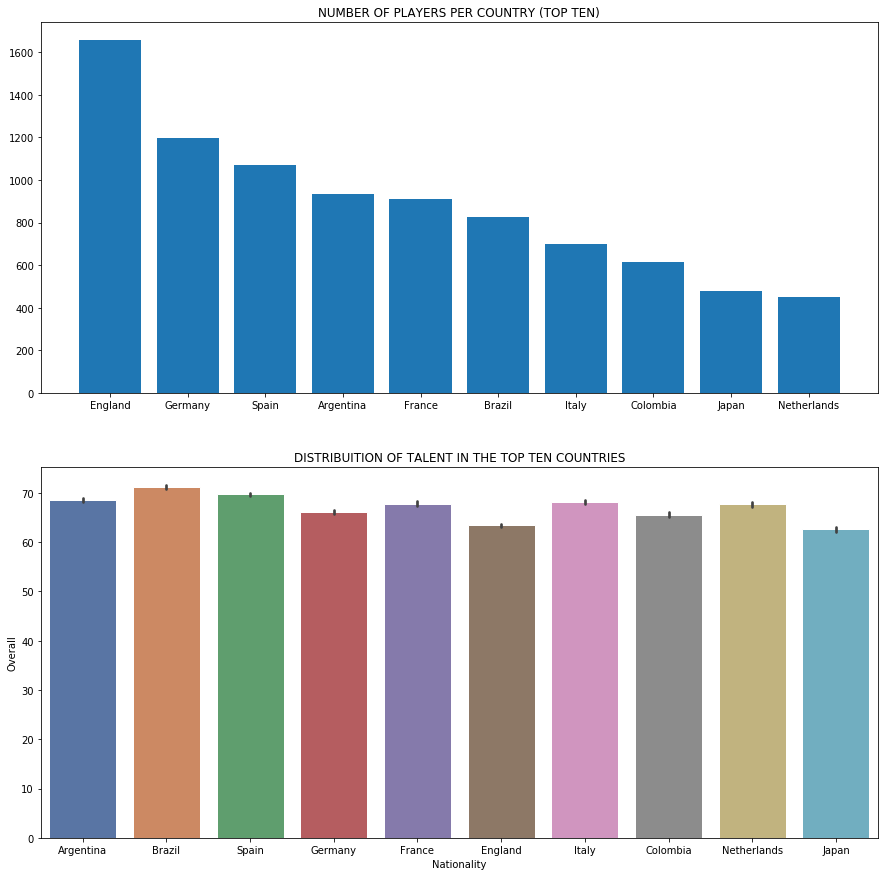

In [12]:

my_count = pd.Series(raw_df["Nationality"]).value_counts()
my_count = my_count[:10] # Keep the first ten countries with most players in the database

#TOP TEN COUNTRIES 
top_ten_countries = raw_df['Nationality'].value_counts().head(10).index.values  
top_ten_countries_data = raw_df.loc[raw_df['Nationality'].isin(top_ten_countries), :]
#TOP TEN COUNTRIES


plt.figure(figsize=(15, 15))
plt.subplot(211)
plt.title('NUMBER OF PLAYERS PER COUNTRY (TOP TEN)')
plt.bar(my_count.index, my_count)

plt.subplot(212)
sns.set(style="white")
plt.title('DISTRIBUITION OF TALENT IN THE TOP TEN COUNTRIES')
p = sns.barplot(x = 'Nationality', y = 'Overall', data = top_ten_countries_data)

plt.show()


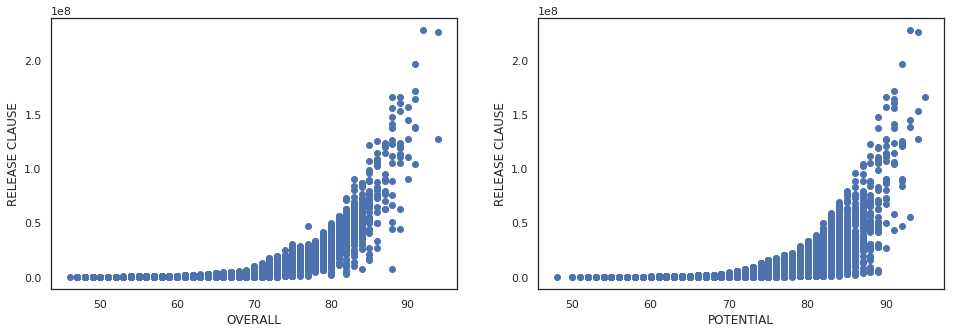

In [13]:
# ADD ALL IMPORTS HERE 
import pandas as pd
from matplotlib import pyplot as plt

plt.figure(figsize=(16, 5))

plt.subplot(121)
plt.xlabel('OVERALL')
plt.ylabel('RELEASE CLAUSE')
#plt.title('WHAT DOES THE MARKET LOOK LIKE?')
plt.scatter(raw_df["Overall"], raw_df["Release Clause"])
plt.subplot(122)
plt.xlabel('POTENTIAL')
plt.ylabel('RELEASE CLAUSE')
#
plt.scatter(raw_df["Potential"], raw_df["Release Clause"])
plt.show()


In [14]:
raw_df.sort_values('Release Clause',inplace=True, ascending=False)
raw_df.loc[:,["Name","Release Clause","Wage","Overall","Potential"]].iloc[:20]#20 players with the biggest Release Clause

,Name,Release Clause,Wage,Overall,Potential
2,Neymar Jr,228100000.0,290000.0,92,93
0,L. Messi,226500000.0,565000.0,94,94
4,K. De Bruyne,196400000.0,355000.0,91,92
5,E. Hazard,172100000.0,340000.0,91,91
25,K. Mbappé,166100000.0,100000.0,88,95
17,A. Griezmann,165800000.0,145000.0,89,90
7,L. Suárez,164000000.0,455000.0,91,91
16,H. Kane,160700000.0,205000.0,89,91
11,T. Kroos,156800000.0,355000.0,90,90
30,Isco,156200000.0,315000.0,88,91


In [15]:
#Sorting the Wage from bigger to smaller
aux = raw_df.copy()
aux.sort_values(by=['Wage'],inplace=True,ascending=False)
aux.loc[:5,["Name","Wage"]]



,Name,Wage
0,L. Messi,565000.0
7,L. Suárez,455000.0
6,L. Modrić,420000.0
1,Cristiano Ronaldo,405000.0
8,Sergio Ramos,380000.0
36,G. Bale,355000.0
4,K. De Bruyne,355000.0
11,T. Kroos,355000.0
5,E. Hazard,340000.0


## Logistic Regression Classifier

In [16]:
def labels(x):
    if x=="Avançado":
        return 2
    if x=="Médio":
        return 1
    if x=="Defesa":
        return 0
    

In [17]:
Nfifa["NField"]=raw_df["Field"].apply(labels).copy()

/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [18]:

dataset=Nfifa.reindex(index=Nfifa["NField"].dropna().index)


In [19]:
msk = np.random.rand(len(dataset)) < 0.8
train = dataset[msk]
test = dataset[~msk]

In [20]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial',C=0.5)
X=train.drop(columns=["NField"])
Y=train["NField"]
LR.fit(X,Y)

/opt/anaconda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [21]:
from sklearn.metrics import confusion_matrix
pred=LR.predict(test.drop(columns=["NField"]))
real=test["NField"]
cm=confusion_matrix(real,pred)
acc=np.trace(cm)/np.sum(cm)
acc

0.872629582806574

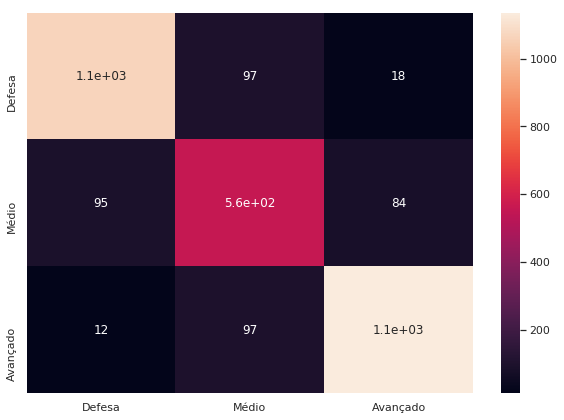

In [22]:

df_cm = pd.DataFrame(cm, index = ["Defesa","Médio","Avançado"],
                  columns = ["Defesa","Médio","Avançado"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

## Prever a posição do Cristiano Ronaldo

In [23]:
disp=raw_df.loc[test.index,["Name","Field"]]
disp["NField"]=test["NField"]
disp["Predicted"]=pred
disp.head(5)

,Name,Field,NField,Predicted
26,M. Salah,Avançado,2.0,2.0
27,Casemiro,Médio,1.0,1.0
28,J. Rodríguez,Médio,1.0,2.0
29,L. Insigne,Avançado,2.0,2.0
31,C. Eriksen,Avançado,2.0,1.0


## O Cristiano é obviamente Avançado!

In [24]:
mask=disp["Predicted"]!=disp["NField"]   #Os que o classificador falhou
disp[mask].head(5)

,Name,Field,NField,Predicted
28,J. Rodríguez,Médio,1.0,2.0
31,C. Eriksen,Avançado,2.0,1.0
76,Iniesta,Avançado,2.0,1.0
86,Koke,Avançado,2.0,1.0
96,A. Vidal,Avançado,2.0,1.0


## Fim do Classificador

## Matriz de Covariancia

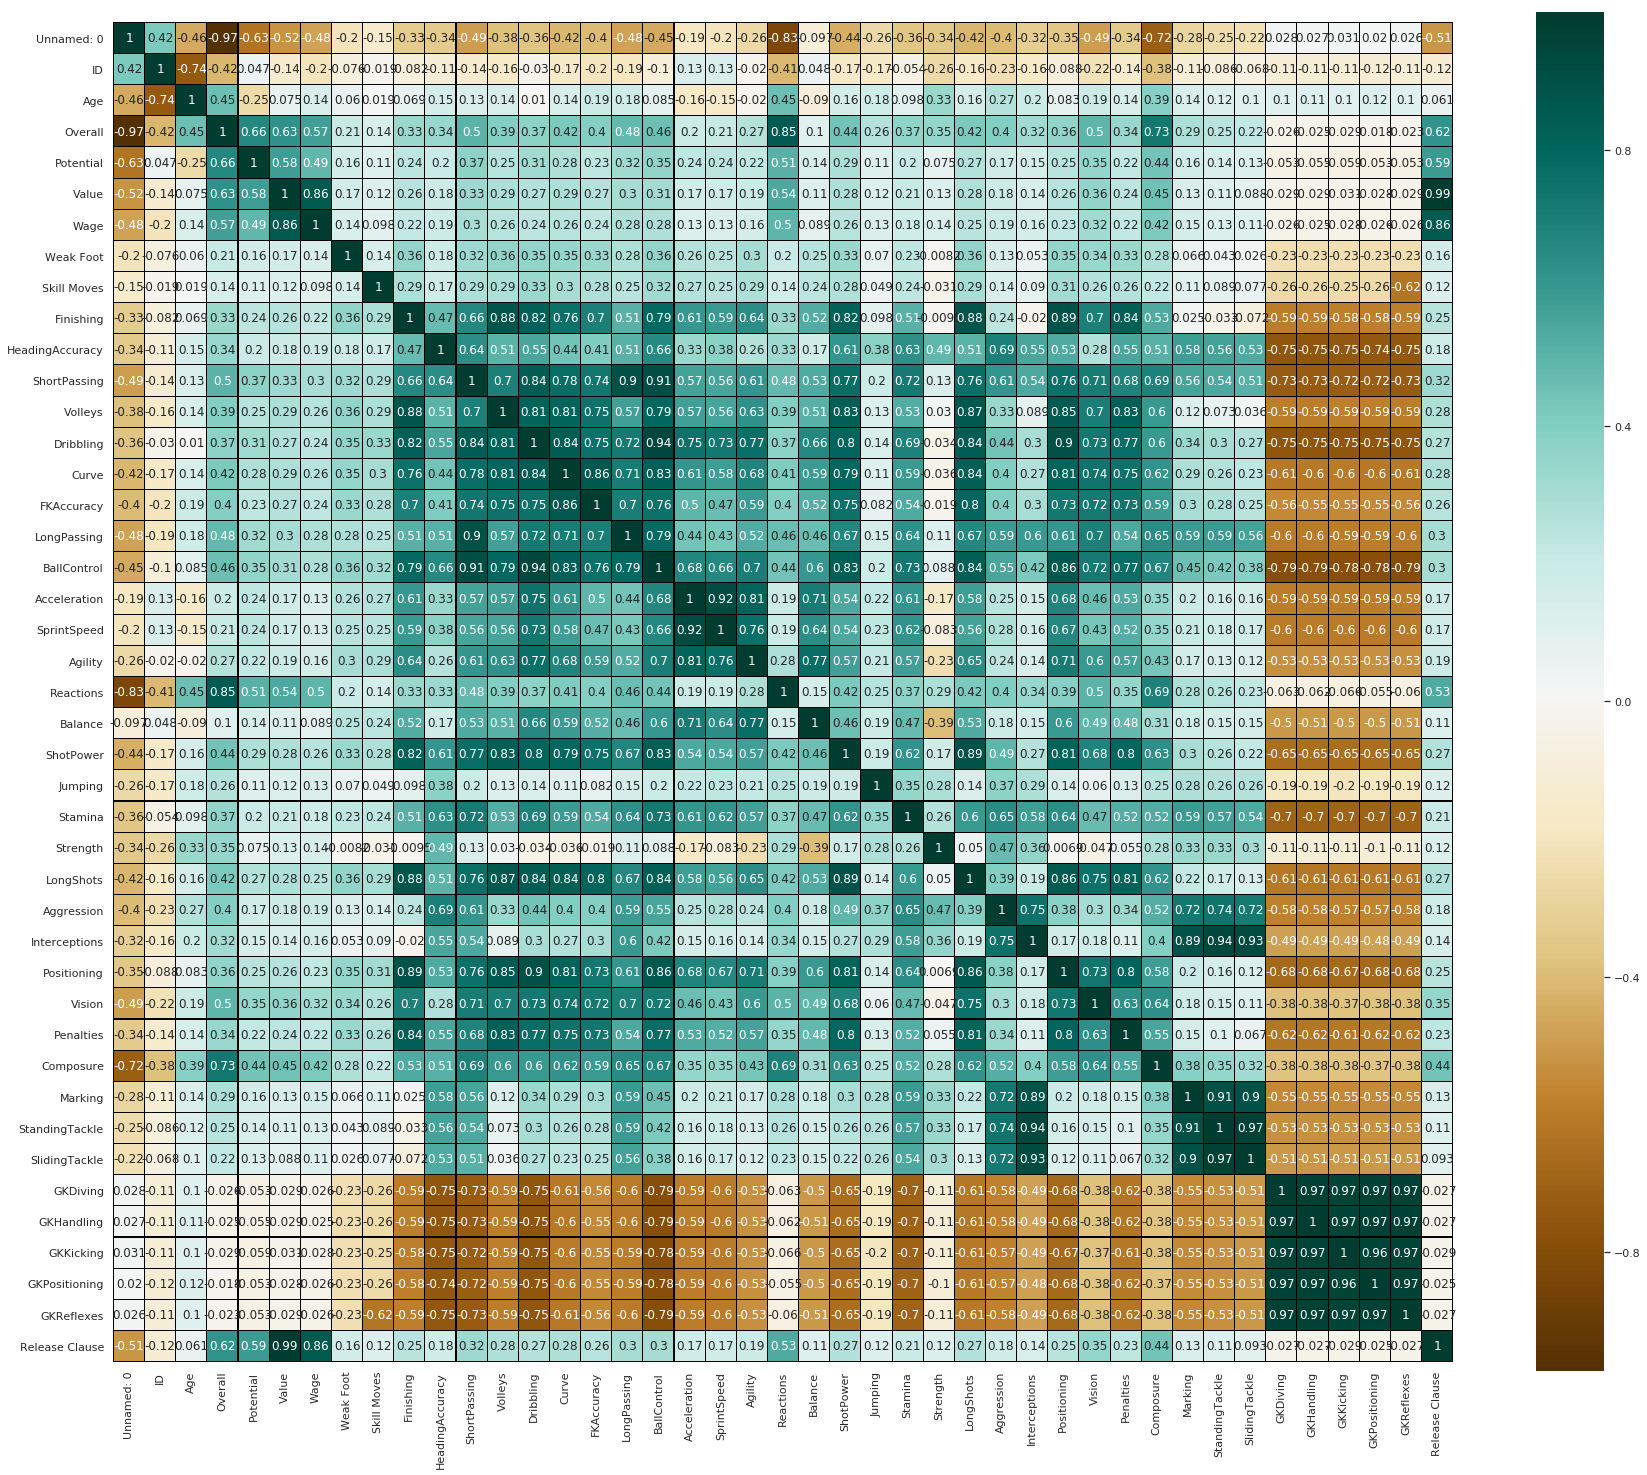

In [25]:
plt.figure(figsize=(30,25))
sns.heatmap(raw_df.corr(),linewidths=0.1,linecolor='black',square=True,cmap="BrBG",annot=True)

## Distribuição do Potencial em função da idade

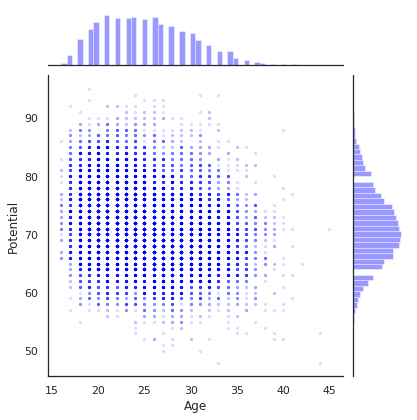

In [26]:

sns.jointplot(x=raw_df['Age'],y=raw_df['Potential'],
              joint_kws={'alpha':0.1,'s':5,'color':'blue'},
              marginal_kws={'color':'blue'})

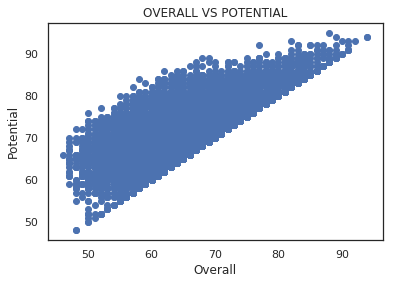

In [27]:
plt.xlabel('Overall')
plt.ylabel('Potential')
plt.title('OVERALL VS POTENTIAL')
plt.scatter(raw_df["Overall"], raw_df["Potential"],)
plt.show()

## Como a idade afeta os jogadores

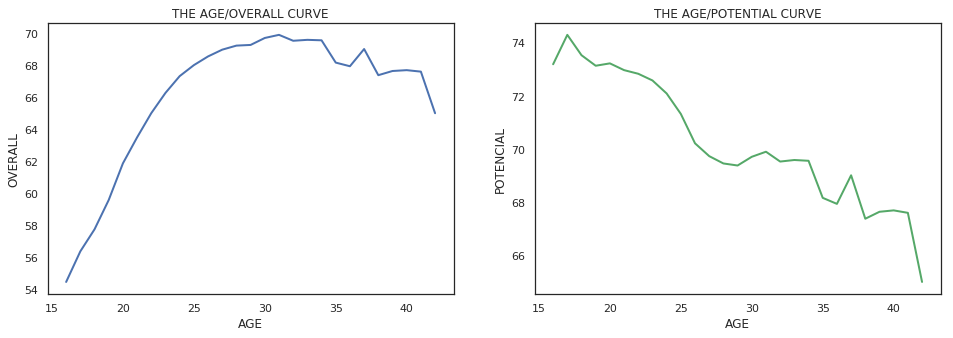

In [28]:
## NÃO MEXER MAIS
#Plotting Mean overall for each age over age

list = range(16,43)
overall = []
pot = []
for i in list:
    overall.append(np.average( raw_df.loc[raw_df['Age']== i ,['Overall']]))
    pot.append(np.average( raw_df.loc[raw_df['Age']== i ,['Potential']]))

plt.figure(figsize=(16, 5))

plt.subplot(121)#1st Pçot
plt.xlabel('AGE')
plt.ylabel('OVERALL')
plt.title('THE AGE/OVERALL CURVE')
lines = plt.plot(list,overall)
plt.setp(lines, 'color', 'b', 'linewidth', 2.0)


plt.subplot(122) #2nd Plot
plt.xlabel('AGE')
plt.ylabel('POTENCIAL')
plt.title('THE AGE/POTENTIAL CURVE')
lines = plt.plot(list,pot)
plt.setp(lines, 'color', 'g', 'linewidth', 2.0)
plt.show()

## Em geral os jogadores Portugueses jogam melhor que a media 

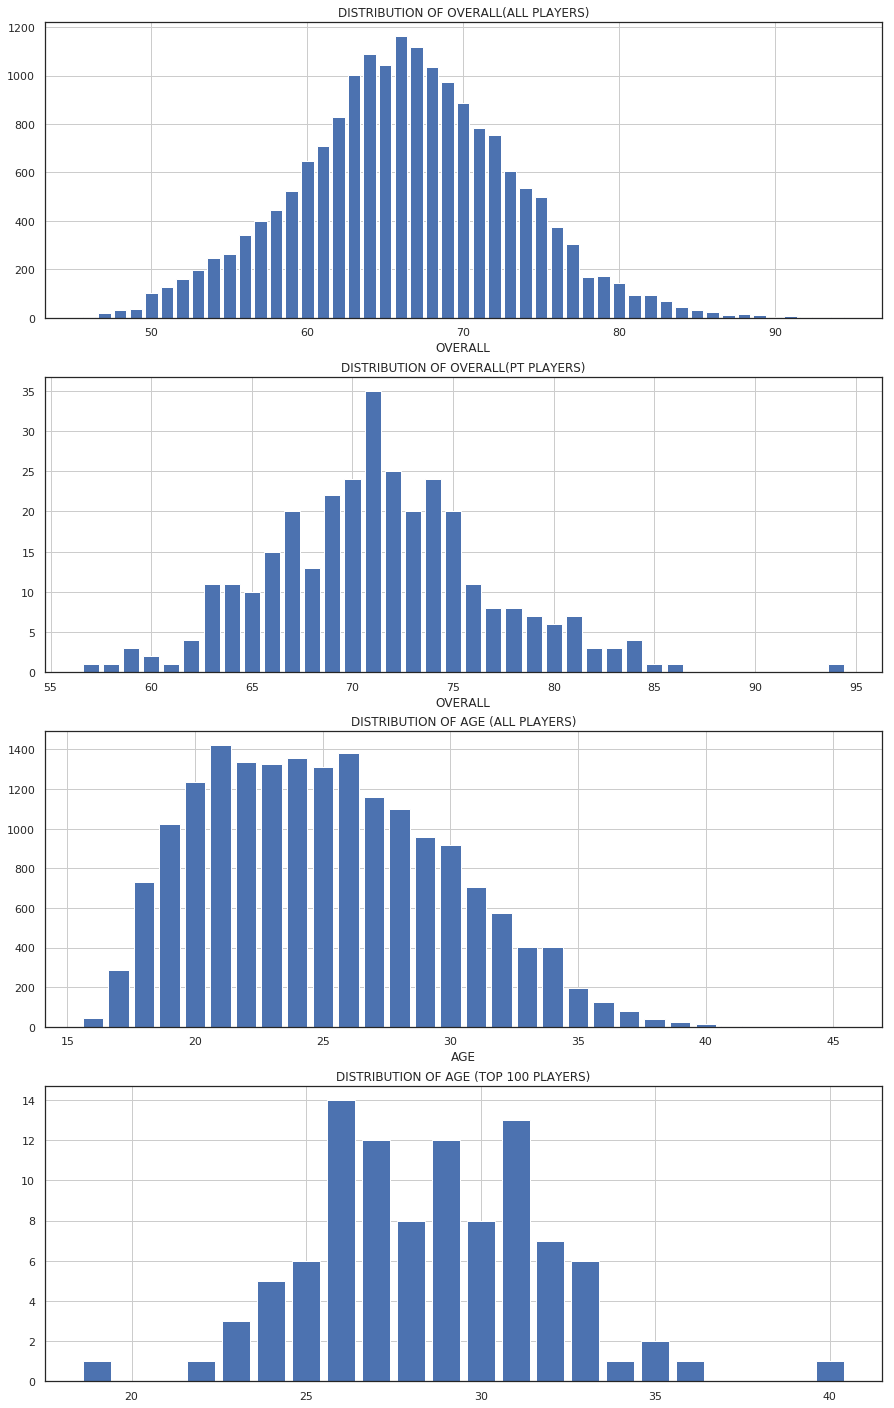

In [29]:
my_overall = pd.Series(raw_df["Overall"]).value_counts()
my_age = pd.Series(raw_df["Age"]).value_counts()

##TOP 100 Players
aux = raw_df.copy()
aux.sort_values("Overall", axis = 0, ascending = False, inplace = True, na_position ='last') 
aux = aux.head(101)
my_age_top100 = pd.Series(aux["Age"]).value_counts()
##TOP 100 Players

my_pt_overall = pd.Series(pt_players["Overall"]).value_counts()


var_overall = np.var(raw_df["Overall"])
ave_overall = np.average(raw_df["Overall"])
var_age = np.var(raw_df["Age"])
ave_age = np.average(raw_df["Age"])

plt.figure(figsize=(15, 25))

plt.subplot(411)
plt.xlabel('OVERALL')
plt.title('DISTRIBUTION OF OVERALL(ALL PLAYERS)')
#plt.subtitle('EVENLY DISTRIBUITED')
plt.bar(my_overall.index, my_overall)
plt.grid(True)

plt.subplot(412)
plt.xlabel('OVERALL')
plt.title('DISTRIBUTION OF OVERALL(PT PLAYERS)')
plt.bar(my_pt_overall.index, my_pt_overall)
plt.grid(True)

plt.subplot(413)
plt.xlabel('AGE')
plt.title('DISTRIBUTION OF AGE (ALL PLAYERS)')
#plt.subtitle('EVENLY DISTRIBUITED')
plt.bar(my_age.index, my_age)
plt.grid(True)


plt.subplot(414)
plt.title('DISTRIBUTION OF AGE (TOP 100 PLAYERS)')
plt.bar(my_age_top100.index, my_age_top100)
plt.grid(True)
plt.show()


In [30]:
aux = raw_df.columns[50:-7].copy()


In [31]:
#Cálculo da diferença da media do overall para cada posição

list = ['Guarda-Redes','Defesa','Médio','Avançado']
world = []
portugal = []
med = []
for i in range(0,4):
    world.append(np.average(raw_df.loc[raw_df['Field']== list[i] ,['Overall']]))
    portugal.append(np.average(pt_players.loc[pt_players['Field']== list[i] ,['Overall']]))
    med.append(world[i]-portugal[i])

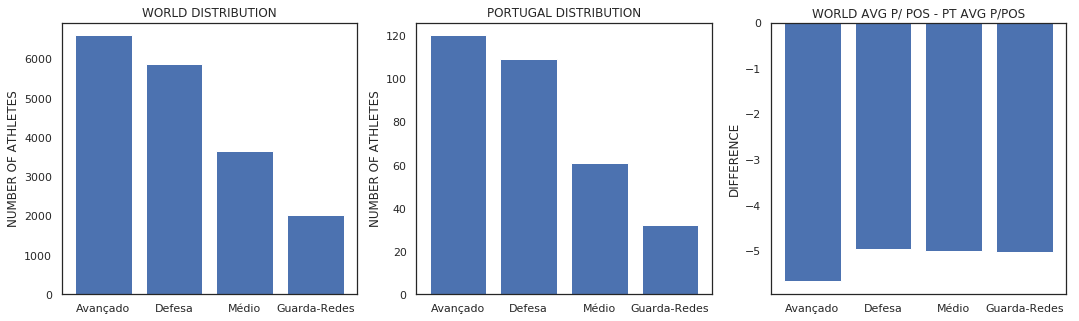

In [32]:
#portuguese_count = pt_players['Field'].value_counts()

plt.figure(figsize=(18, 5))
plt.subplot(131)
plt.ylabel('NUMBER OF ATHLETES')
plt.title('WORLD DISTRIBUTION')
plt.bar(world_count.index, world_count)

plt.subplot(132)
plt.ylabel('NUMBER OF ATHLETES')
plt.title('PORTUGAL DISTRIBUTION')
plt.bar(portuguese_count.index, portuguese_count)

plt.subplot(133)
plt.ylabel('DIFFERENCE')
plt.title('WORLD AVG P/ POS - PT AVG P/POS')
plt.bar(portuguese_count.index, med)

plt.show()

In [33]:
list = ['Defesa','Médio','Avançado']

ml_players= raw_df.loc[raw_df['Field'].isin(list) & raw_df['Field']]
ml_players.head(6)

,Unnamed: 0,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,...,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,Unnamed: 89,Field
2,2,190871,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,118500000.0,290000.0,...,24.0,33.0,9.0,9.0,15.0,15.0,11.0,228100000.0,NaN,Avançado
0,0,158023,L. Messi,31,Argentina,94,94,FC Barcelona,110500000.0,565000.0,...,28.0,26.0,6.0,11.0,15.0,14.0,8.0,226500000.0,NaN,Avançado
4,4,192985,K. De Bruyne,27,Belgium,91,92,Manchester City,102000000.0,355000.0,...,58.0,51.0,15.0,13.0,5.0,10.0,13.0,196400000.0,NaN,Médio
5,5,183277,E. Hazard,27,Belgium,91,91,Chelsea,93000000.0,340000.0,...,27.0,22.0,11.0,12.0,6.0,8.0,8.0,172100000.0,NaN,Avançado
25,25,231747,K. Mbappé,19,France,88,95,Paris Saint-Germain,81000000.0,100000.0,...,34.0,32.0,13.0,5.0,7.0,11.0,6.0,166100000.0,NaN,Avançado
17,17,194765,A. Griezmann,27,France,89,90,Atlético Madrid,78000000.0,145000.0,...,47.0,48.0,14.0,8.0,14.0,13.0,14.0,165800000.0,NaN,Avançado


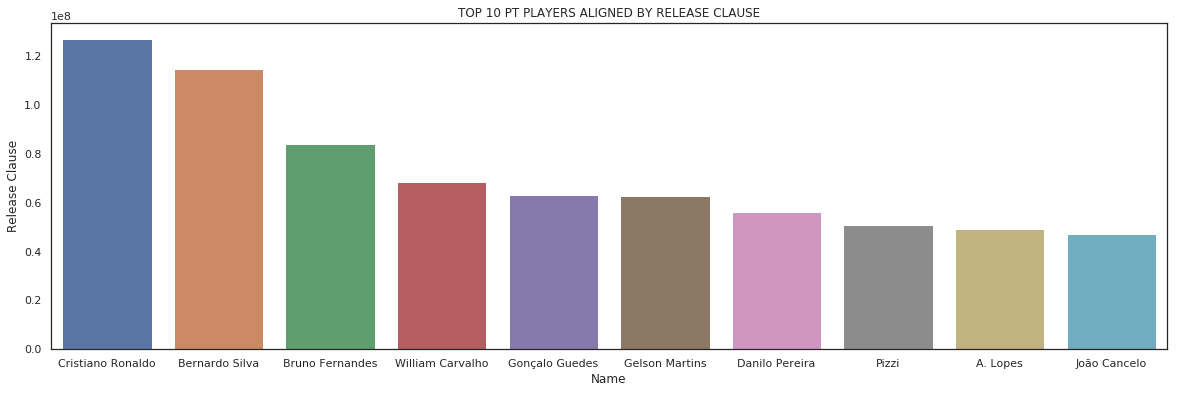

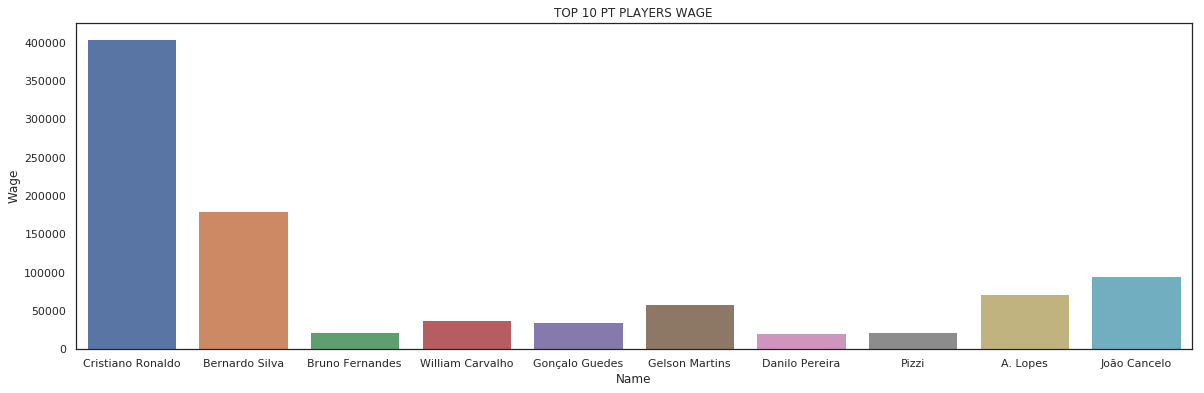

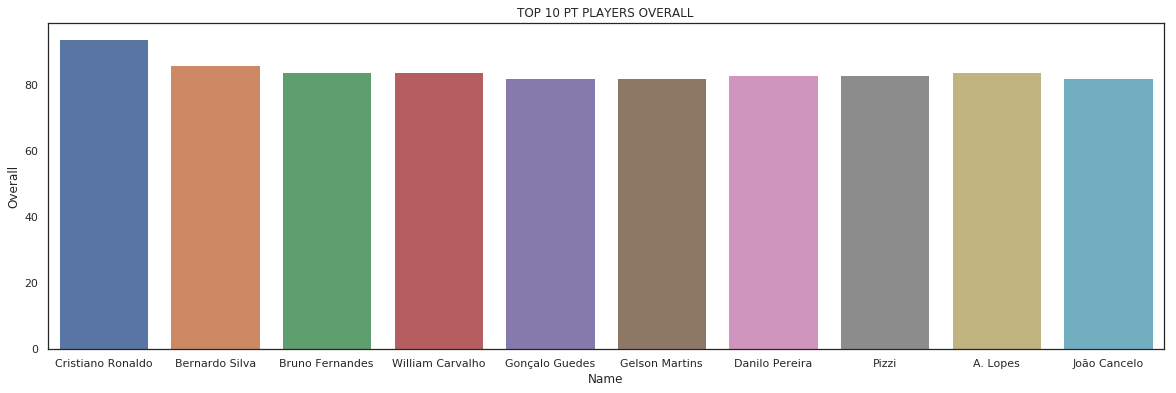

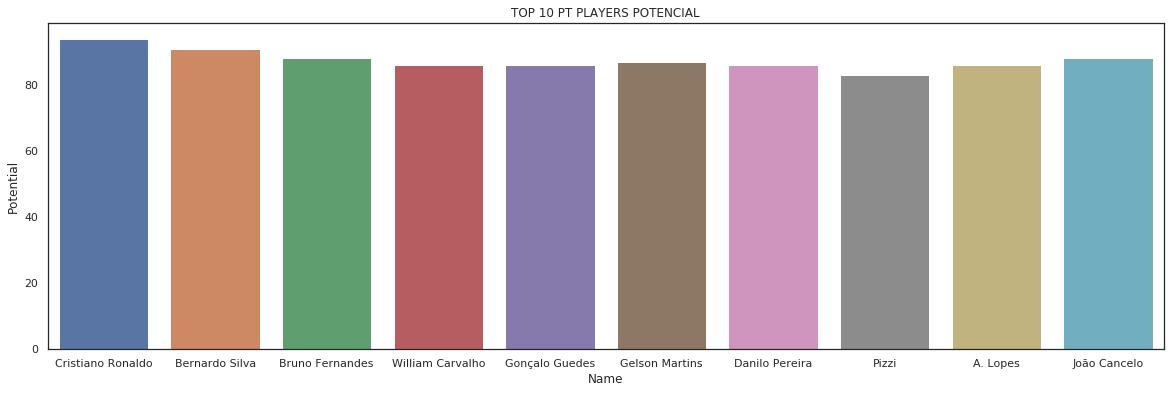

In [34]:
#OLHAR SÓ PARA PORTUGAL
pt_players.sort_values('Release Clause',inplace=True, ascending=False)
top_ten_players = pt_players.head(10).index.values  
top_ten_players_data = pt_players.head(10)

plt.figure(figsize=(20, 6))
plt.title('TOP 10 PT PLAYERS ALIGNED BY RELEASE CLAUSE')
p = sns.barplot(x = 'Name', y = 'Release Clause', data = top_ten_players_data)

plt.figure(figsize=(20, 6))
plt.title('TOP 10 PT PLAYERS WAGE')
p = sns.barplot(x = 'Name', y = 'Wage', data = top_ten_players_data)

plt.figure(figsize=(20, 6))
plt.title('TOP 10 PT PLAYERS OVERALL')
p = sns.barplot(x = 'Name', y = 'Overall', data = top_ten_players_data)

plt.figure(figsize=(20, 6))
plt.title('TOP 10 PT PLAYERS POTENCIAL')
p = sns.barplot(x = 'Name', y = 'Potential', data = top_ten_players_data)
